In [149]:
import sys
import os

In [150]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt
import math
sys.path.insert(1, '../utils')
from utils import *
from utils import plot_solution
from utils import score
from typing import Callable
from abc import ABC, abstractmethod
from sortedcontainers import SortedList

In [151]:
a=pd.read_csv('../data/TSPA.csv', sep=';', header=None)
b=pd.read_csv('../data/TSPB.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])
tspb=pd.DataFrame(data=b.values, columns=['x', 'y', 'val'])
coordinates=tspa[['x', 'y']].values
coordinatesb=tspb[['x', 'y']].values
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)
distb=distance_matrix(coordinatesb, coordinatesb)
distb=np.round(distb)
costs=tspa[['val']].values
costsb=tspb[['val']].values

In [152]:
class Neighborhood(ABC):
    @abstractmethod
    def neighborhood_size(self):
        pass

    @abstractmethod
    def get_difference(self, ind, solution: List[int], unselected):
        pass

    @abstractmethod
    def modify_solution(self, ind, solution: List[int], unselected):
        pass


In [166]:
class NodeNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = list()
        for i in range(n-1):
            for j in range(i+1, n):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = solution[(j-1)%n]
        j2 = solution[j%n]
        j3 = solution[(j+1)%n]
        #edge case when two consecutive nodes selected
        if i-j == -1:
            return -self.dist_mat[i1, i2] - self.dist_mat[i2, j2] - self.dist_mat[j2, j3] \
                + self.dist_mat[i1, j2] + self.dist_mat[j2, i2] + self.dist_mat[i2, j3]
        
        difference = -self.dist_mat[i1, i2] - self.dist_mat[i2, i3] - self.dist_mat[j1, j2] - self.dist_mat[j2, j3] \
            + self.dist_mat[i1, j2] + self.dist_mat[j2, i3] + self.dist_mat[j1, i2] + self.dist_mat[i2, j3]
        return difference
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i], solution[j] = solution[j], solution[i]
        return solution

In [195]:
class EdgeNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.distance_matrix = distance_matrix
        self.costs = costs
        self.indexes = list()
        for i in range(1, n-1):
            m = n - 1 if i == 1 else n
            for j in range(i+1, m):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]

        i1 = solution[i - 1]
        i2 = solution[i]

        j1 = solution[j]
        j2 = solution[(j + 1)%n]

        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i:j+1] = solution[j:i-1:-1]
        return solution


In [165]:
from typing import List


class InterNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = list()
        m = len(self.dist_mat) - n
        for i in range(n):
            for j in range(m):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = unselected[j]

        return -self.dist_mat[i1, i2] -self.dist_mat[i2, i3] + self.dist_mat[i1, j1] + self.dist_mat[j1, i3]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        current_node = solution[i]
        solution[i] = unselected[j]
        unselected.remove(unselected[j])
        unselected.add(current_node)
        return solution

In [167]:
class CombinedNeighborhood(Neighborhood):
    def __init__(self , neighborhoods: List[Neighborhood]) -> None:
        self.neighborhoods = neighborhoods
        self.size = sum(n.neighborhood_size() for n in self.neighborhoods)

    def neighborhood_size(self):
        return self.size
    
    def get_difference(self, ind, solution: List[int], unselected):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.get_difference(ind, solution, unselected)
            ind -= size

    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.modify_solution(ind, solution, unselected)
            ind -= size

In [238]:
def greedy(starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, neighborhood: Neighborhood) -> list:
    cost_matrix = (distance_matrix + costs).T
    n = len(distance_matrix)
    num_nodes_to_use = n // 2
    unselected = SortedList(range(len(costs)))
    for i in starting_solution:
        unselected.remove(i)
    solution = starting_solution.copy()
    print(score(solution, distance_matrix, costs))
    for _ in range(int(1e9)):
        objective_changes = [neighborhood.get_difference(i, solution, unselected)
                            for i in range(neighborhood.neighborhood_size())]
        best_index = np.argmin(objective_changes)
        if objective_changes[i] >= 0:
            return solution
        solution = neighborhood.modify_solution(best_index, solution, unselected)
        print(score(solution, distance_matrix, costs), objective_changes[i])
    return solution


In [252]:
def get_random_solution(n: int) -> list[int]:
    a=np.arange(0,n)
    np.random.shuffle(a)

    return list(a[:int(np.ceil(n/2))])

In [253]:
n = len(costs)
initial_solution = get_random_solution(n)
neighborhood1 = EdgeNeighborhood(dist, costs, n // 2)
neighborhood2 = InterNeighborhood(dist, costs, n // 2)
neighborhood = CombinedNeighborhood([neighborhood1, neighborhood2])
neighborhood.neighborhood_size()

14850

In [254]:
solution = greedy(initial_solution, dist, costs, neighborhood)

257262
250906 -40.0
244867 -131.0
238868 -131.0
232920 -131.0


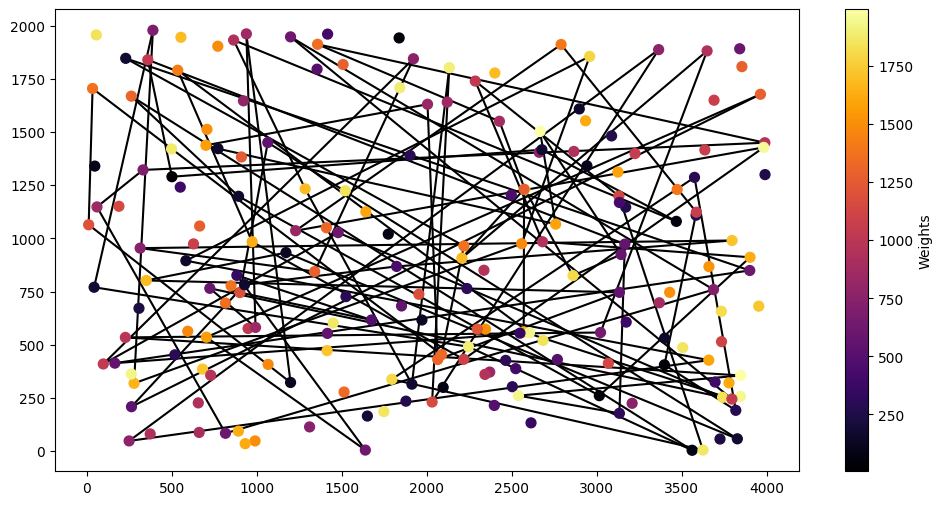

In [247]:
plot_solution(solution, coordinates, costs, '')

scores of nn:  105852 115630.16 123171
[159, 195, 146, 22, 20, 18, 108, 67, 36, 140, 93, 117, 170, 153, 183, 89, 23, 83, 64, 15, 9, 37, 128, 172, 57, 55, 3, 32, 49, 102, 144, 132, 21, 7, 164, 71, 27, 39, 165, 8, 185, 174, 81, 98, 17, 157, 188, 56, 171, 16, 78, 25, 44, 120, 2, 75, 86, 97, 189, 94, 130, 137, 66, 176, 80, 151, 133, 79, 63, 136, 53, 180, 154, 6, 135, 194, 161, 123, 29, 126, 112, 4, 190, 177, 147, 48, 34, 160, 184, 28, 43, 65, 197, 59, 118, 60, 46, 198, 139, 193]


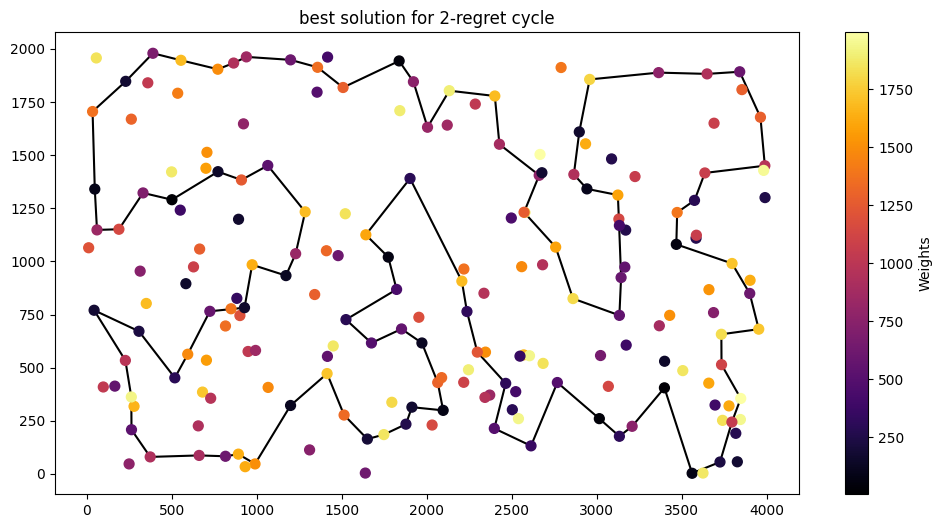

In [75]:
scores_2=[]
sols_2=[]

for x in range(200):
   
    solution_2=greedy_2_regret_cycle2(x, dist, costs)
    sols_2.append(solution_2)

    scores_2.append(score(solution_2, dist, costs))   

print('scores of nn: ', min(scores_2), sum(scores_2)/len(scores_2), max(scores_2))
print(sols_2[scores_2.index(min(scores_2))])
plot_solution(sols_2[scores_2.index(min(scores_2))], coordinates, costs, 'best solution for 2-regret cycle')
sol_1=np.array(sols_2[scores_2.index(min(scores_2))])
pd.DataFrame(sol_1).to_csv('sol_1.csv', header=False, index=False)

In [81]:
%%timeit
greedy_2_regret_cycle2(0, dist, costs)

12.3 ms ± 70.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
%%timeit
greedy_2_regret_weighted(0, dist, costs)

12.7 ms ± 193 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
